In [1]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.2/124.9 MB 4.5 MB/s eta 0:00:28
   ---------------------------------------- 0.3/124.9 MB 3.4 MB/s eta 0:00:37
   ---------------------------------------- 0.3/124.9 MB 3.5 MB/s eta 0:00:36
   ---------------------------------------- 0.3/124.9 MB 3.5 MB/s eta 0:00:36
   ---------------------------------------- 0.3/124.9 MB 3.5 MB/s eta 0:00:36
   ---------------------------------------- 0.3/124.9 MB 3.5 MB/s eta 0:00:36
   ---------------------------------------- 0.3/124.9 MB 3.5 MB/s eta 0:00:36
   ---------------------------------------- 0.3/124.9 MB 1.0 MB/s eta 0:01:59
   ---------------------------------------- 0.4/124.9 MB 1.1 MB/s eta 0:01:54
   ---------------------------------------- 0.4/124.9 MB 1.1 MB/s eta 0:01:54
   ---------------------------------------- 0.4/124.9 MB 1.1 MB/s eta 0:01:54
   ---------------------------------------- 0.4/124.9 MB 1.1 MB/s eta 0

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Mean Squared Error: 0.7060102317272914
R-squared Score: 0.8549997851374427
Mean Absolute Error: 0.631104760342446
Mean Squared Error: 4.125497328480704
R-squared Score: 0.026328500279285905
Mean Absolute Error: 1.6845673893116135


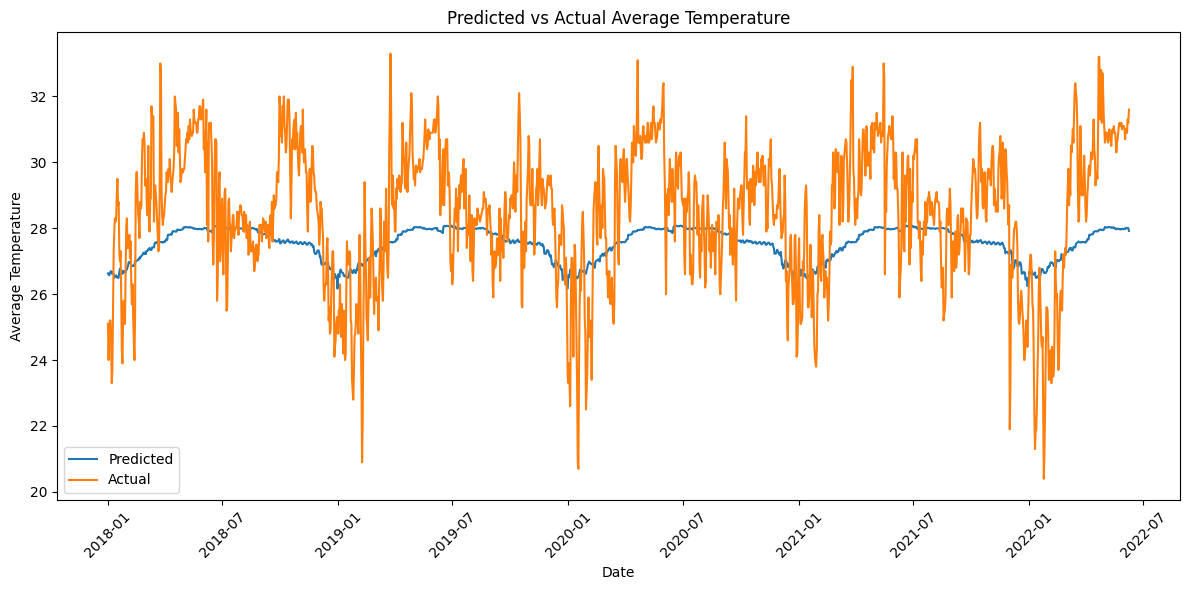

           time  predicted_tavg  tavg
0    2018-01-01       26.630888  25.1
1    2018-01-02       26.603863  24.0
2    2018-01-03       26.572599  24.8
3    2018-01-04       26.629059  25.2
4    2018-01-05       26.681795  25.2
...         ...             ...   ...
1615 2022-06-04       28.011806  30.9
1616 2022-06-05       28.011806  30.9
1617 2022-06-06       28.004128  31.3
1618 2022-06-07       28.003559  31.2
1619 2022-06-08       27.918690  31.6

[1620 rows x 3 columns]
Results successfully saved to C:/Users/Intern13/Desktop/project/qtm/dataset/wether/answer.csv

First few rows of the combined dataframe:
        time  predicted_tavg  tavg
0 2018-01-01       26.630888  25.1
1 2018-01-02       26.603863  24.0
2 2018-01-03       26.572599  24.8
3 2018-01-04       26.629059  25.2
4 2018-01-05       26.681795  25.2

Total number of rows in the dataframe: 1620


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import os
import xgboost as xgb

# Load the training data
train_data = pd.read_csv(r'C:\Users\Intern13\Desktop\project\qtm\dataset\wether\train.csv')

# Convert 'time' column to datetime
train_data['time'] = pd.to_datetime(train_data['time'], format='%d-%m-%Y')

# Sort the data by time
train_data = train_data.sort_values('time')

# Fill null values using interpolation
train_data = train_data.interpolate(method='linear').ffill().bfill()

# Convert all columns (except 'time') to numeric type
for col in train_data.columns:
    if col != 'time':
        train_data[col] = pd.to_numeric(train_data[col], errors='coerce').fillna(0)

# Extract additional time-based features
train_data['day_of_year'] = train_data['time'].dt.dayofyear
train_data['month'] = train_data['time'].dt.month
train_data['day_of_week'] = train_data['time'].dt.dayofweek
train_data['is_weekend'] = train_data['day_of_week'] >= 5
train_data['quarter'] = train_data['time'].dt.quarter

# Prepare features (X) and target variable (y)
features = ['tmin', 'tmax', 'prcp', 'day_of_year', 'month', 'day_of_week', 'is_weekend', 'quarter']
X = train_data[features]
y = train_data['tavg']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data for cross-validation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Perform hyperparameter tuning for XGBRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model from grid search
model = grid_search.best_estimator_

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Mean Absolute Error: {mae}")

# Generate prediction dates
prediction_start_date = pd.to_datetime("01-01-2018", format='%d-%m-%Y')
num_months = 54
prediction_dates = pd.date_range(start=prediction_start_date, periods=num_months*30, freq='D')

# Function to create features for a given date
def create_features(date, historical_data):
    return pd.DataFrame({
        'tmin': [historical_data[historical_data['time'] < date]['tmin'].mean()],
        'tmax': [historical_data[historical_data['time'] < date]['tmax'].mean()],
        'prcp': [historical_data[historical_data['time'] < date]['prcp'].mean()],
        'day_of_year': [date.dayofyear],
        'month': [date.month],
        'day_of_week': [date.dayofweek],
        'is_weekend': [date.dayofweek >= 5],
        'quarter': [date.quarter]
    })

# Make predictions
predictions = []
for date in prediction_dates:
    features = create_features(date, train_data)
    features_scaled = scaler.transform(features)
    pred = model.predict(features_scaled)
    predictions.append(pred[0])

# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'time': prediction_dates,
    'predicted_tavg': predictions
})

# Load the comparison data
comparison_data = pd.read_csv(r'C:\Users\Intern13\Desktop\project\qtm\dataset\wether\test.csv')
comparison_data['time'] = pd.to_datetime(comparison_data['time'], format='%d-%m-%Y')

# Merge predictions with actual data
combined_df = pd.merge(predictions_df, comparison_data[['time', 'tavg']], on='time', how='left')

# Calculate error metrics for the period where we have actual data
mask = combined_df['tavg'].notnull()
mse = mean_squared_error(combined_df.loc[mask, 'tavg'], combined_df.loc[mask, 'predicted_tavg'])
r2 = r2_score(combined_df.loc[mask, 'tavg'], combined_df.loc[mask, 'predicted_tavg'])
mae = mean_absolute_error(combined_df.loc[mask, 'tavg'], combined_df.loc[mask, 'predicted_tavg'])

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Mean Absolute Error: {mae}")

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(combined_df['time'], combined_df['predicted_tavg'], label='Predicted')
plt.plot(combined_df['time'], combined_df['tavg'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Predicted vs Actual Average Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the predictions
print(combined_df)

# Save the results to a CSV file
output_file = 'C:/Users/Intern13/Desktop/project/qtm/dataset/wether/answer.csv'

try:
    # Ensure the directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Save the file
    combined_df.to_csv(output_file, index=False)
    print(f"Results successfully saved to {output_file}")
except PermissionError:
    print(f"Permission denied: Unable to save to {output_file}. Please check your write permissions for this location.")
except IOError as e:
    print(f"An error occurred while saving the file: {e}")
    print("Please check if the path is correct and you have the necessary permissions.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    print("Please check your file path and permissions.")

# Print the first few rows of the dataframe to verify the data
print("\nFirst few rows of the combined dataframe:")
print(combined_df.head())

# Print the total number of rows in the dataframe
print(f"\nTotal number of rows in the dataframe: {len(combined_df)}")
